# *Der Algorithmus* - kurz und erklärt


Zuerst nimmt der Raspberry Pi ein Bild auf und extrahiert den Rotkanal (Farbe des Lasers). Das ist hier bereits geschehen, das Bild befindet sich in der Datei `holmos_raw.png`.
In folgendem Code-Abschnitt wird das Bild in die Variable `image` geladen und angezeigt.

<IPython.core.display.Javascript object>


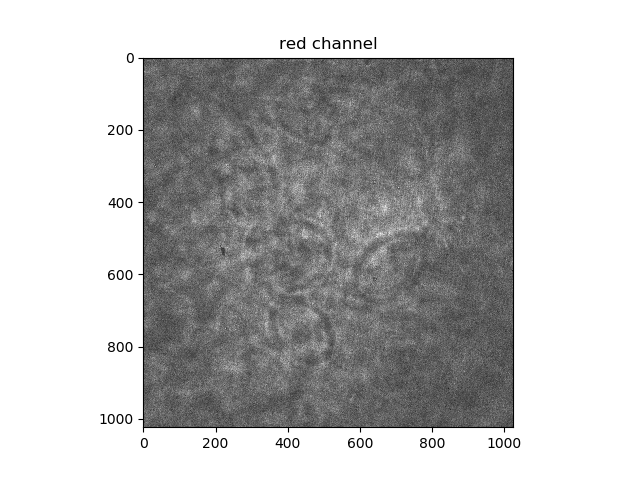

In [5]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Rectangle:
    def __init__(self):
        self.x = self.y = self.width = self.height = 0

# Load image from file
image = (plt.imread('holmos_raw.png') * 255).astype(np.uint8)
width = image.shape[0]
height = image.shape[1]

plt.figure()
plt.title('red channel')
plt.imshow(image, cmap='gray')
plt.show()

Jetzt wird das Bild fouriertransformiert. Da dies komplexe Werte zurückliefert, nehmen wir für die Anzeige die absoluten Werte(`np.abs`).

Interessant ist für uns aber nur der kleine Bereich der in grün eingezeichnet ist.

<IPython.core.display.Javascript object>


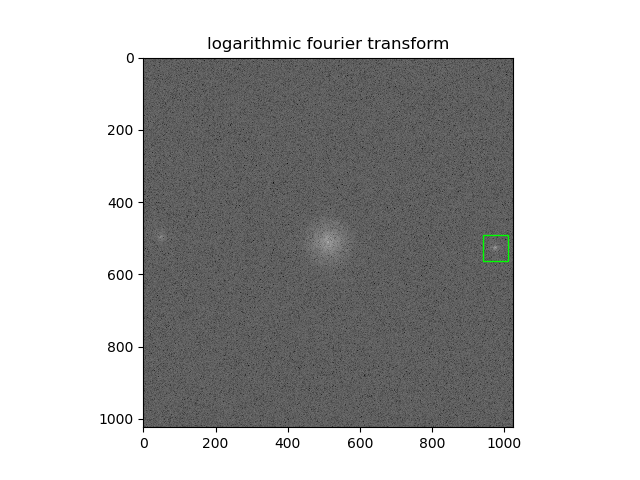

In [6]:
fourier_space = np.fft.fftshift(np.fft.fft2(image))
log_fourier = np.log(np.abs(fourier_space))

rect_center_x = width - 49
rect_center_y = height / 2 + 15
rect_radius = 35
rect = Rectangle()
rect.x = int(rect_center_x - rect_radius)
rect.y = int(rect_center_y - rect_radius)
rect.width = rect.height = int(rect_radius * 2)

fig, ax = plt.subplots(1)
plt.title('logarithmic fourier transform')
plt.imshow(log_fourier, cmap='gray')
ax.add_patch(patches.Rectangle((rect.x, rect.y), rect.width, rect.height, fill=False, edgecolor="#00ff00"))
plt.show()

Dieser grüne Bereich wird aus dem Fourierspektrum ausgeschnitten und in die Bildmitte eines neuen Bildes kopiert (`fourier_shifted`).

<IPython.core.display.Javascript object>


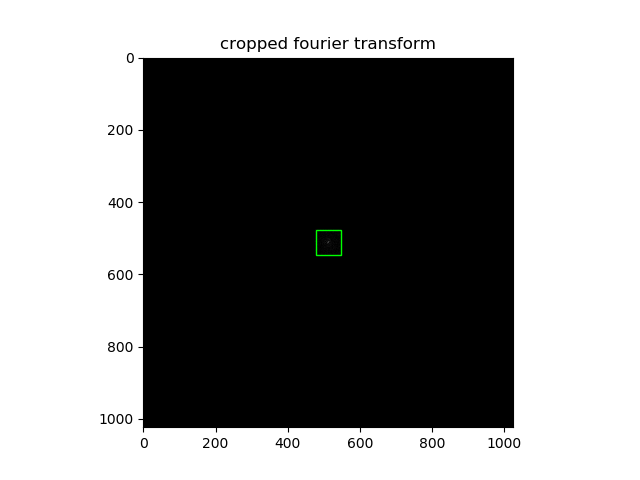

In [7]:
# Shift the fourier
fft_shifted = np.zeros_like(fourier_space)
x1 = width // 2 - rect.width // 2
x2 = width // 2 + rect.width // 2
y1 = height // 2 - rect.height // 2
y2 = height // 2 + rect.height // 2

fft_shifted[y1:y2, x1:x2] = fourier_space[rect.y:rect.y+rect.height, rect.x:rect.x + rect.width]

fig, ax = plt.subplots(1)
plt.title("cropped fourier transform")
plt.imshow(np.abs(fft_shifted), cmap='gray')
ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="#00ff00"))
plt.show()


Danach wird das Bild rücktransformiert. Der Winkel der komplexen Zahlen repräsentiert dann die Phase der Wellenfront.

Einziges Problem: Bei Gangunterschieden der Welle $>\lambda$ lässt sich kein Unterschied feststellen, was die Sprünge im Bild erklärt. Hierzu muss dieses erst verstetigt werden.

<IPython.core.display.Javascript object>


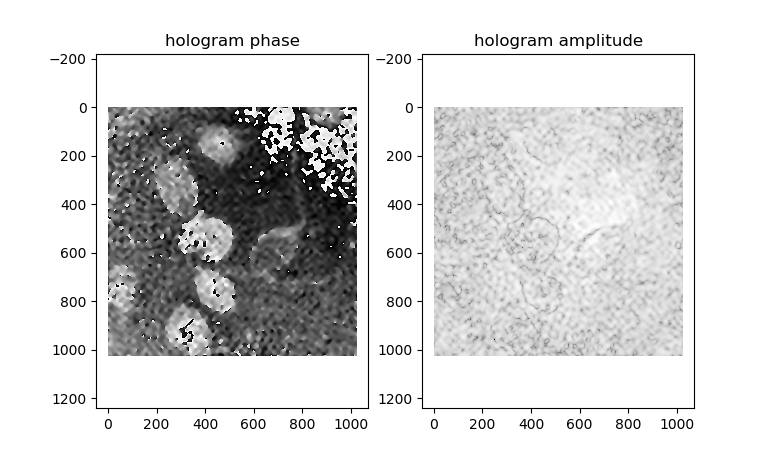

In [10]:
hologram = np.fft.ifft2(np.fft.fftshift(fft_shifted))
holo_phase = np.angle(hologram)
holo_logamp = np.log(np.abs(hologram))

plt.figure()
ax1 = plt.subplot(121)
plt.title("hologram phase")
plt.imshow(holo_phase, cmap='gray')
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.title("hologram amplitude")
plt.imshow(holo_logamp, cmap='gray')
plt.show()

## Verstetigung

<IPython.core.display.Javascript object>


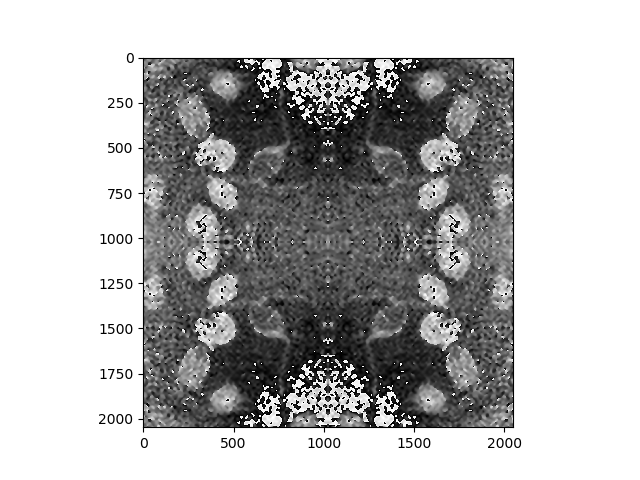

In [11]:
mirrored = np.zeros([width*2, height*2])
mirrored[:height, :width] = holo_phase
mirrored[height:, :width] = holo_phase[::-1,:]
mirrored[height:, width:] = holo_phase[::-1, ::-1]
mirrored[:height, width:] = holo_phase[:, ::-1]

plt.figure()
plt.imshow(mirrored, cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


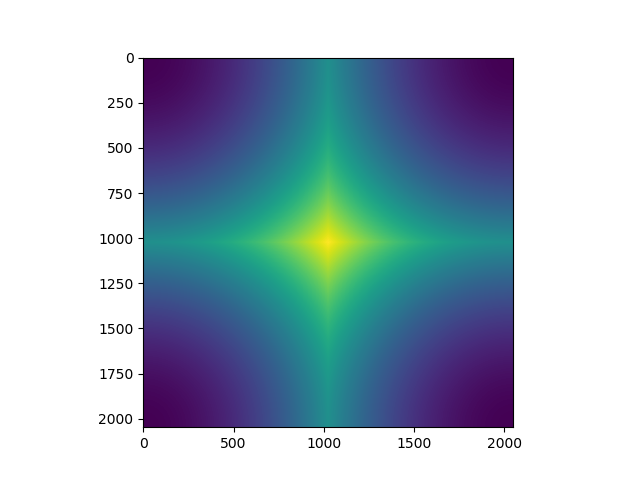

In [12]:
# Create r² array
x2 = np.arange(-height, height)
y2 = np.arange(-width, width)
x2 = x2**2
y2 = y2**2
x2 = np.roll(x2, height)
y2 = np.roll(y2, width)
r2s = np.add.outer(x2, y2)
r2s = r2s.astype(np.float32)
r2s += 1e-10 # bitte keine Null
plt.imsave("rsquared.png", r2s, cmap='gray')

plt.figure()
plt.imshow(r2s)
plt.show()

In [13]:
holo_cos = np.cos(mirrored)
holo_sin = np.sin(mirrored)

dt = np.fft.fft2
idt = np.fft.ifft2

phi_prime = r2s**-1.0*dt(holo_cos*idt(r2s*dt(holo_sin)) - holo_sin*idt(r2s*dt(holo_cos)))
phi_prime = idt(phi_prime)

phi_ = phi_prime.real[:height, :width]

<IPython.core.display.Javascript object>


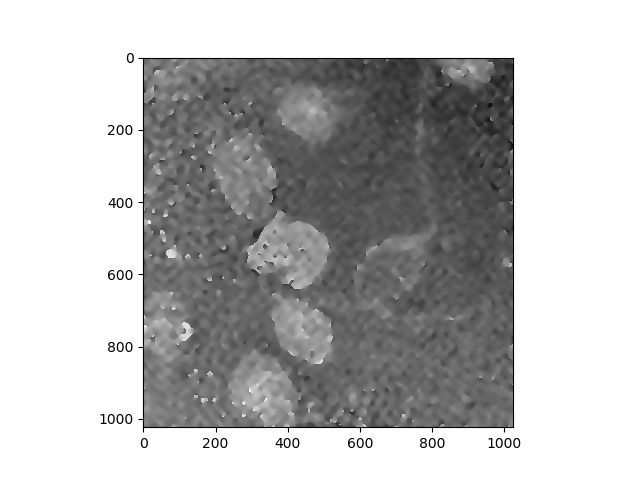

In [14]:
unwrapped_phase = (holo_phase + 2*np.pi*np.round((phi_ - holo_phase) / 2 / np.pi))

plt.figure()
plt.imshow(unwrapped_phase, cmap='gray')
plt.show()